## Add the private Kaggle dataset as an Input -->

In [96]:
# Import libraries
import os
import sys
import psutil
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import warnings
import time
from torch.amp import autocast, GradScaler
import torch
import torchvision.transforms as T
from transformers import DetrForObjectDetection
from torch.optim import AdamW
from tqdm.auto import tqdm
import random
from sklearn.metrics import classification_report
import torchvision.ops as ops
from sklearn.metrics import f1_score
import cv2
from torch.utils.data import DataLoader

# Filter out PyTorch warning about meta parameters when loading model
warnings.filterwarnings("ignore", message=".*copying from a non-meta parameter.*")

In [3]:
# Get helper scripts from GitHub
!wget https://raw.githubusercontent.com/apmalinsky/AAI-590-Capstone/refs/heads/main/scripts/dataloader.py
!wget https://raw.githubusercontent.com/apmalinsky/AAI-590-Capstone/refs/heads/main/scripts/detection_batch_prep.py

--2025-12-01 23:38:36--  https://raw.githubusercontent.com/apmalinsky/AAI-590-Capstone/refs/heads/main/scripts/dataloader.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4645 (4.5K) [text/plain]
Saving to: ‘dataloader.py’

dataloader.py       100%[===================>]   4.54K  --.-KB/s    in 0s      

2025-12-01 23:38:36 (40.4 MB/s) - ‘dataloader.py’ saved [4645/4645]

--2025-12-01 23:38:36--  https://raw.githubusercontent.com/apmalinsky/AAI-590-Capstone/refs/heads/main/scripts/detection_batch_prep.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting resp

In [4]:
# Import helper scripts
from dataloader import get_dataloaders
from detection_batch_prep import prepare_batch

In [5]:
# View data file
data_path = '/kaggle/input/rsna-2022-hdf5-subset/fracture_dataset_subset.h5'

# Open the file
with h5py.File(data_path, 'r') as f:
    # View key list, essentially our 'columns'
    print(f'Keys: {list(f.keys())}')

    # View column shapes
    for key in f.keys():
        dataset = f[key]
        print(f'\nKey: {key}')
        print(f'Shape: {dataset.shape}')
        print(f'Dtype: {dataset.dtype}')

Keys: ['SliceNumber', 'StudyInstanceUID', 'bboxes', 'images', 'labels', 'split']

Key: SliceNumber
Shape: (28812,)
Dtype: object

Key: StudyInstanceUID
Shape: (28812,)
Dtype: object

Key: bboxes
Shape: (28812, 10, 4)
Dtype: float32

Key: images
Shape: (28812, 256, 256)
Dtype: float32

Key: labels
Shape: (28812,)
Dtype: int8

Key: split
Shape: (28812,)
Dtype: int8


In [6]:
# Get the number of physical CPU core
physical_cores = psutil.cpu_count(logical=False)
# Get the number of logical CPU cores (threads)
logical_cores = psutil.cpu_count(logical=True)

print(f'Physical CPU cores available: {physical_cores}')
print(f'Logical CPU cores (max workers) available: {logical_cores}')

Physical CPU cores available: 2
Logical CPU cores (max workers) available: 4


In [41]:
# Configure parameters
batch_size = 100
num_workers = 2 # Increase workers to max available
learning_rate = 1e-4
backbone_lr = 1e-5
weight_decay = 1e-3 # We increase weight_decay to 1e-3 to prevent the training loss from dropping too fast (overfitting)
num_epochs = 40
report_interval = 5      # Detailed report epoch frequency
patience = 20             # Stop early if no improvement for this many epochs
conf_threshold = 0.1     # Low threshold to monitor "potential" recall during training
image_size = 256
save_metric = 'f1'
device = 'cuda' if torch.cuda.is_available() else 'cpu' # for gpu acceleration
print(f'Using device: {device}')

Using device: cuda


In [10]:
# Apply data augmentation to prevent overfitting and memorization
# Applies safe augmentations, ones that do not move the bounding box
train_augs = T.Compose([
    T.ToPILImage(),
    T.ColorJitter(brightness=0.3, contrast=0.3), # Stronger lighting variation
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)), # Simulate blur
    T.ToTensor(),
])

In [42]:
# Get data loaders for detection
train_loader_det, val_loader_det, test_loader_det = get_dataloaders(
    hdf5_path=data_path,
    batch_size=batch_size,
    task='detection',
    num_workers=num_workers,
    train_transform=train_augs
)

Loading dataset for task: 'detection'...
Loading splits...
DataLoaders created.


In [43]:
# Setup pre-trained DETR model
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    num_labels=1,
    ignore_mismatched_sizes=True,
    low_cpu_mem_usage=False
)
model.to(device)
print('DETR model loaded to device.')

# Freeze weights in early CNN layers to focus/speedup training for detection
for name, param in model.model.backbone.conv_encoder.model.named_parameters():
    if "conv1" in name or "bn1" in name or "layer1" in name or "layer2" in name:
        param.requires_grad = False
print('Froze early CNN layers.')


# Set params and learning rates for optimizer
param_dicts = [
    # Transformer params
    {
        "params": [p for n, p in model.named_parameters() if "backbone" not in n and p.requires_grad],
        "lr": learning_rate,
    },
    # Backbone params
    {
        "params": [p for n, p in model.named_parameters() if "backbone" in n and p.requires_grad],
        "lr": backbone_lr,
    },
]
optimizer = AdamW(param_dicts, lr=learning_rate, weight_decay=weight_decay)
print('Model initialized with balanced settings (anti-overfitting).')

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

DETR model loaded to device.
Froze early CNN layers.
Model initialized with balanced settings (anti-overfitting).


In [50]:
# Define helper function to process predictions by DETR model
def process_detr_predictions(outputs, conf_threshold=0.1, image_size=256):
    # Get probability for "Fracture" class (index 0)
    probas = outputs.logits.softmax(-1)[..., 0]
    # Create mask for boxes above threshold
    keep = probas > conf_threshold

    # Convert relative [cx, cy, w, h] to absolute [x1, y1, x2, y2]
    pred_boxes = outputs.pred_boxes.float()
    cx, cy, w, h = pred_boxes.unbind(-1)
    x1 = (cx - 0.5 * w) * image_size
    y1 = (cy - 0.5 * h) * image_size
    x2 = (cx + 0.5 * w) * image_size
    y2 = (cy + 0.5 * h) * image_size
    pred_xyxy = torch.stack([x1, y1, x2, y2], dim=-1)

    return keep, pred_xyxy

In [51]:
# Define evaluation function for detection and classification metrics
def evaluate_dual_metrics(model, dataloader, device, conf_threshold=0.1, iou_threshold=0.5):
    model.eval()
    cls_y_true, cls_y_pred = [], [] # for classification
    det_y_true, det_y_pred = [], [] # for detection
    
    print(f'Starting Dual Evaluation (Conf: {conf_threshold}, IoU: {iou_threshold})...')
    
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc='Evaluating'):
            pixel_values, _ = prepare_batch(images, targets, device, image_size=256, model_type='detr')
            outputs = model(pixel_values=pixel_values)

            # Process model predictions
            keep, pred_xyxy = process_detr_predictions(outputs, conf_threshold)

            # Loop through batch
            for i in range(len(images)):
                gt_boxes = targets[i]['boxes'].to(device) # Get ground truth boxes
                img_pred_boxes = pred_xyxy[i][keep[i]] # Filter predictions for this image
                
                # Classification metrics
                has_fracture = len(gt_boxes) > 0 # True if patient has fracture, False if healthy
                pred_fracture = len(img_pred_boxes) > 0 # True if model predicts any fracture box
                cls_y_true.append(1 if has_fracture else 0)
                cls_y_pred.append(1 if pred_fracture else 0)
                
                # Detection metrics
                if len(gt_boxes) > 0: # Only evaluate detection if there is something to detect
                    if len(img_pred_boxes) > 0:
                        # For detection, calculate intersection over union (IoU) to compare bounding boxes
                        # Calculate IoU between all ground truth and all predictions
                        ious = ops.box_iou(gt_boxes, img_pred_boxes)
                        
                        # For each GT box, did we find a matching prediction?
                        # We take the max IoU for each GT box
                        max_ious_per_gt, _ = ious.max(dim=1)
                        
                        # A "Hit" is when the best overlap is > 0.5
                        is_detected = max_ious_per_gt > iou_threshold
                        
                        det_y_true.extend([1] * len(gt_boxes)) # All GTs are "1" (should be found)
                        det_y_pred.extend(is_detected.int().tolist())
                    else:
                        # We missed all boxes
                        det_y_true.extend([1] * len(gt_boxes))
                        det_y_pred.extend([0] * len(gt_boxes))

    # Print reports
    print('\n' + '='*60)
    print('CLASSIFICATION REPORT (Patient Diagnosis)')
    print(classification_report(cls_y_true, cls_y_pred, target_names=['Healthy', 'Fracture'], zero_division=0))

    print('\n' + '='*60)
    print('DETECTION REPORT (Localization)')
    print(classification_report(det_y_true, det_y_pred, target_names=['Missed Box', 'Found Box'], zero_division=0))

In [52]:
# Check baseline (untrained) performance
print('Calculating Baseline Metrics ...')
evaluate_dual_metrics(model, val_loader_det, device)

Calculating Baseline Metrics ...
Starting Dual Evaluation (Conf: 0.1, IoU: 0.5)...


Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


CLASSIFICATION REPORT (Patient Diagnosis)
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00      3135
    Fracture       0.25      1.00      0.40      1045

    accuracy                           0.25      4180
   macro avg       0.12      0.50      0.20      4180
weighted avg       0.06      0.25      0.10      4180


DETECTION REPORT (Localization)
              precision    recall  f1-score   support

  Missed Box       0.00      0.00      0.00         0
   Found Box       1.00      0.11      0.20      1045

    accuracy                           0.11      1045
   macro avg       0.50      0.06      0.10      1045
weighted avg       1.00      0.11      0.20      1045



In [55]:
# Define validation function to be used during training
def run_validation(model, dataloader, device, conf_threshold=0.1, iou_threshold=0.5):
    model.eval()
    total_loss = 0.0
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc='Validating', leave=False):
            pixel_values, labels = prepare_batch(images, targets, device, image_size=256, model_type='detr')
            with torch.amp.autocast('cuda'):
                outputs = model(pixel_values=pixel_values, labels=labels)
                if outputs.loss is not None:
                    total_loss += outputs.loss.item()
            
            # Process model predictions
            keep, pred_xyxy = process_detr_predictions(outputs, conf_threshold)
            
            for i in range(len(images)):
                gt_boxes = targets[i]['boxes'].to(device)
                pred_boxes = pred_xyxy[i][keep[i]]            # Filter by confidence
                
                if len(gt_boxes) > 0:
                    # Patient has fracture
                    if len(pred_boxes) > 0:
                        # Check overlap (IoU)
                        ious = ops.box_iou(gt_boxes, pred_boxes)
                        
                        # If any predicted box overlaps any gt box by > 0.5, it's a hit
                        if (ious.max() > iou_threshold).item():
                            true_positives += 1
                        else:
                            # Predicted a box, but in the wrong place
                            false_negatives += 1 
                            false_positives += 1 # Penalize for bad box
                    else:
                        # Missed completely
                        false_negatives += 1
                else:
                    # Healthy Patient
                    if len(pred_boxes) > 0:
                        false_positives += 1 # False alarm

    # Calculate scores
    avg_loss = total_loss / len(dataloader)
    
    precision = true_positives / (true_positives + false_positives + 1e-6)
    recall = true_positives / (true_positives + false_negatives + 1e-6)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)
    
    return avg_loss, f1_score, recall, precision

In [56]:
# Training loop, optimizing for best f1-score
scaler = GradScaler('cuda')

# Tracking metric history
best_f1 = 0.0
early_stopping_counter = 0
history = {'train_loss': [], 'val_loss': [], 'f1': [], 'recall': [], 'precision': []}

print(f'Starting Training Loop (Target: Best F1-Score, {conf_threshold} conf)...')

start_time = time.time()

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss_accum = 0.0
    pbar = tqdm(train_loader_det, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    
    for images, targets in pbar:
        pixel_values, labels = prepare_batch(images, targets, device, image_size=256, model_type='detr')
        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        scaler.step(optimizer)
        scaler.update()

        train_loss_accum += loss.item()
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})
        
    avg_train_loss = train_loss_accum / len(train_loader_det)
    history['train_loss'].append(avg_train_loss)

    # Validation Phase
    avg_val_loss, val_f1, val_recall, val_prec = run_validation(
        model, val_loader_det, device, conf_threshold=conf_threshold
    )
    
    history['val_loss'].append(avg_val_loss)
    history['f1'].append(val_f1)
    history['recall'].append(val_recall)
    history['precision'].append(val_prec)
    
    print(f'  -> Loss: Train={avg_train_loss:.4f} Val={avg_val_loss:.4f}')
    print(f'  -> Metrics: F1={val_f1:.2%} | Recall={val_recall:.2%} | Prec={val_prec:.2%}')
    
    # Saving logic (best F1)
    if val_f1 > best_f1:
        print(f'  [*] NEW BEST F1! ({best_f1:.2%} -> {val_f1:.2%}). Saving "detr_best_f1.pth"...')
        best_f1 = val_f1
        best_recall_at_f1 = val_recall
        torch.save(model.state_dict(), 'detr_best_f1.pth')
        early_stopping_counter = 0 
    else:
        early_stopping_counter += 1
        print(f'  [!] No improvement. Patience: {early_stopping_counter}/{patience}')

    if early_stopping_counter >= patience:
        print('\n[STOP] Early stopping triggered.')
        break

total_time = (time.time() - start_time) / 60
print(f'\nTraining Finished in {total_time:.1f} minutes.')

Starting Training Loop (Target: Best F1-Score, 0.1 conf)...


Epoch 1/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x7cc8219fae80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/usr/local/lib/python3.11/dist-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm' object has no attribute 'disp'


Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=1.8797 Val=1.6076
  -> Metrics: F1=0.00% | Recall=0.00% | Prec=0.00%
  [!] No improvement. Patience: 1/20


Epoch 2/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x7cc8219fae80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/usr/local/lib/python3.11/dist-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm' object has no attribute 'disp'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cc85fda8360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=1.6470 Val=1.5740
  -> Metrics: F1=0.00% | Recall=0.00% | Prec=0.00%
  [!] No improvement. Patience: 2/20


Epoch 3/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=1.4988 Val=1.5397
  -> Metrics: F1=1.67% | Recall=0.86% | Prec=25.71%
  [*] NEW BEST F1! (0.00% -> 1.67%). Saving "detr_best_f1.pth"...


Epoch 4/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=1.4267 Val=1.5234
  -> Metrics: F1=0.00% | Recall=0.00% | Prec=0.00%
  [!] No improvement. Patience: 1/20


Epoch 5/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=1.3415 Val=1.5506
  -> Metrics: F1=0.00% | Recall=0.00% | Prec=0.00%
  [!] No improvement. Patience: 2/20


Epoch 6/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=1.2832 Val=1.4956
  -> Metrics: F1=1.89% | Recall=1.05% | Prec=9.17%
  [*] NEW BEST F1! (1.67% -> 1.89%). Saving "detr_best_f1.pth"...


Epoch 7/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=1.2236 Val=1.3836
  -> Metrics: F1=11.41% | Recall=11.67% | Prec=11.15%
  [*] NEW BEST F1! (1.89% -> 11.41%). Saving "detr_best_f1.pth"...


Epoch 8/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=1.1900 Val=1.3781
  -> Metrics: F1=13.59% | Recall=13.68% | Prec=13.49%
  [*] NEW BEST F1! (11.41% -> 13.59%). Saving "detr_best_f1.pth"...


Epoch 9/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=1.1442 Val=1.4520
  -> Metrics: F1=5.20% | Recall=2.97% | Prec=21.09%
  [!] No improvement. Patience: 1/20


Epoch 10/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=1.1164 Val=1.4615
  -> Metrics: F1=10.21% | Recall=7.56% | Prec=15.71%
  [!] No improvement. Patience: 2/20


Epoch 11/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=1.0812 Val=1.4014
  -> Metrics: F1=15.50% | Recall=16.08% | Prec=14.96%
  [*] NEW BEST F1! (13.59% -> 15.50%). Saving "detr_best_f1.pth"...


Epoch 12/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=1.0575 Val=1.3823
  -> Metrics: F1=13.81% | Recall=11.20% | Prec=18.03%
  [!] No improvement. Patience: 1/20


Epoch 13/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=1.0359 Val=1.4117
  -> Metrics: F1=5.88% | Recall=3.54% | Prec=17.29%
  [!] No improvement. Patience: 2/20


Epoch 14/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=1.0426 Val=1.4315
  -> Metrics: F1=13.42% | Recall=9.28% | Prec=24.19%
  [!] No improvement. Patience: 3/20


Epoch 15/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=1.0019 Val=1.4287
  -> Metrics: F1=11.10% | Recall=11.20% | Prec=11.01%
  [!] No improvement. Patience: 4/20


Epoch 16/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=0.9780 Val=1.4881
  -> Metrics: F1=18.23% | Recall=18.09% | Prec=18.37%
  [*] NEW BEST F1! (15.50% -> 18.23%). Saving "detr_best_f1.pth"...


Epoch 17/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=0.9592 Val=1.4585
  -> Metrics: F1=5.92% | Recall=3.16% | Prec=47.14%
  [!] No improvement. Patience: 1/20


Epoch 18/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=0.9366 Val=1.4801
  -> Metrics: F1=15.90% | Recall=11.58% | Prec=25.37%
  [!] No improvement. Patience: 2/20


Epoch 19/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=0.9245 Val=1.4489
  -> Metrics: F1=14.96% | Recall=11.39% | Prec=21.79%
  [!] No improvement. Patience: 3/20


Epoch 20/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=0.9103 Val=1.4995
  -> Metrics: F1=16.12% | Recall=12.63% | Prec=22.26%
  [!] No improvement. Patience: 4/20


Epoch 21/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=0.8827 Val=1.4380
  -> Metrics: F1=14.09% | Recall=15.41% | Prec=12.98%
  [!] No improvement. Patience: 5/20


Epoch 22/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=0.8743 Val=1.4841
  -> Metrics: F1=14.90% | Recall=19.81% | Prec=11.94%
  [!] No improvement. Patience: 6/20


Epoch 23/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=0.8714 Val=1.4971
  -> Metrics: F1=17.06% | Recall=21.44% | Prec=14.17%
  [!] No improvement. Patience: 7/20


Epoch 24/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=0.8455 Val=1.4877
  -> Metrics: F1=15.33% | Recall=13.78% | Prec=17.27%
  [!] No improvement. Patience: 8/20


Epoch 25/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=0.8459 Val=1.5768
  -> Metrics: F1=8.41% | Recall=5.74% | Prec=15.71%
  [!] No improvement. Patience: 9/20


Epoch 26/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=0.8215 Val=1.5003
  -> Metrics: F1=14.95% | Recall=17.80% | Prec=12.88%
  [!] No improvement. Patience: 10/20


Epoch 27/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=0.8138 Val=1.4740
  -> Metrics: F1=13.90% | Recall=10.14% | Prec=22.08%
  [!] No improvement. Patience: 11/20


Epoch 28/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=0.8042 Val=1.4864
  -> Metrics: F1=13.15% | Recall=13.68% | Prec=12.65%
  [!] No improvement. Patience: 12/20


Epoch 29/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=0.8006 Val=1.4206
  -> Metrics: F1=13.32% | Recall=14.83% | Prec=12.09%
  [!] No improvement. Patience: 13/20


Epoch 30/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=0.7984 Val=1.4111
  -> Metrics: F1=14.56% | Recall=16.94% | Prec=12.76%
  [!] No improvement. Patience: 14/20


Epoch 31/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=0.7765 Val=1.5949
  -> Metrics: F1=13.17% | Recall=11.39% | Prec=15.62%
  [!] No improvement. Patience: 15/20


Epoch 32/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=0.7859 Val=1.5160
  -> Metrics: F1=11.79% | Recall=12.54% | Prec=11.12%
  [!] No improvement. Patience: 16/20


Epoch 33/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=0.7787 Val=1.5299
  -> Metrics: F1=13.28% | Recall=15.12% | Prec=11.84%
  [!] No improvement. Patience: 17/20


Epoch 34/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=0.7712 Val=1.6079
  -> Metrics: F1=18.87% | Recall=24.69% | Prec=15.27%
  [*] NEW BEST F1! (18.23% -> 18.87%). Saving "detr_best_f1.pth"...


Epoch 35/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=0.7387 Val=1.4616
  -> Metrics: F1=12.95% | Recall=14.45% | Prec=11.73%
  [!] No improvement. Patience: 1/20


Epoch 36/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=0.7234 Val=1.4808
  -> Metrics: F1=14.72% | Recall=19.43% | Prec=11.84%
  [!] No improvement. Patience: 2/20


Epoch 37/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=0.7201 Val=1.5647
  -> Metrics: F1=16.08% | Recall=18.66% | Prec=14.12%
  [!] No improvement. Patience: 3/20


Epoch 38/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=0.7256 Val=1.4982
  -> Metrics: F1=16.99% | Recall=19.04% | Prec=15.34%
  [!] No improvement. Patience: 4/20


Epoch 39/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=0.6986 Val=1.4746
  -> Metrics: F1=13.58% | Recall=15.98% | Prec=11.81%
  [!] No improvement. Patience: 5/20


Epoch 40/40 [Train]:   0%|          | 0/208 [00:00<?, ?it/s]

Validating:   0%|          | 0/42 [00:00<?, ?it/s]

  -> Loss: Train=0.6990 Val=1.4378
  -> Metrics: F1=15.22% | Recall=17.61% | Prec=13.40%
  [!] No improvement. Patience: 6/20

Training Finished in 117.62647601366044 minutes.


In [62]:
# Get training and validation metric history for plots
train_losses = history['train_loss']
val_losses = history['val_loss']
val_f1s = history['f1']
val_recalls = history['recall']
val_precisions = history['precision']

# Find the best epoch (Max f1 score)
best_idx = np.argmax(val_f1s)
best_epoch = best_idx + 1

t_loss = train_losses[:best_idx+1]
v_loss = val_losses[:best_idx+1]
v_f1 = val_f1s[:best_idx+1]
v_recall = val_recalls[:best_idx+1]
v_precision = val_precisions[:best_idx+1]
epochs = range(1, best_epoch + 1)

print(f'Best Validation f1: {val_f1s[best_idx]:.4f} at Epoch {best_epoch}')

Best Validation f1: 0.1887 at Epoch 34


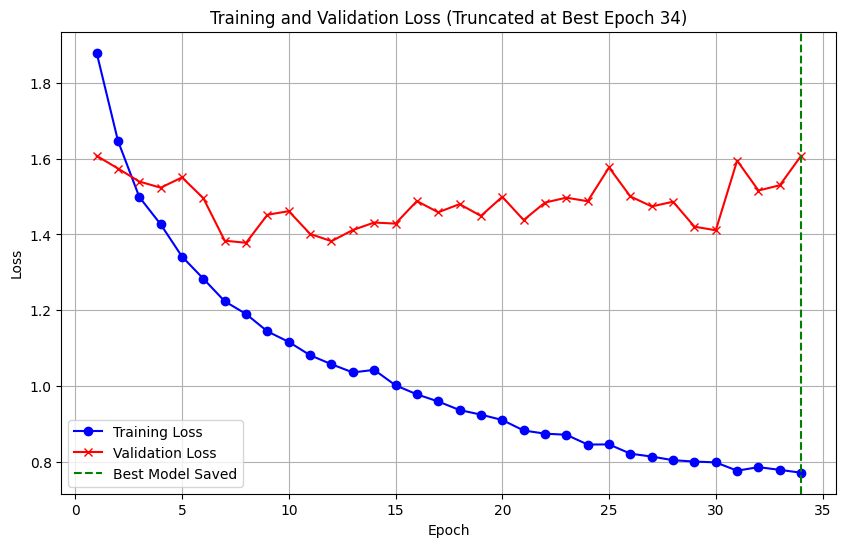

In [59]:
# Plot training and validation loss until best epoch
plt.figure(figsize=(10, 6))
plt.plot(epochs, t_loss, label='Training Loss', marker='o', color='blue')
plt.plot(epochs, v_loss, label='Validation Loss', marker='x', color='red')
plt.axvline(x=best_epoch, color='green', linestyle='--', label='Best Model Saved')
plt.title(f'Training and Validation Loss (Truncated at Best Epoch {best_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

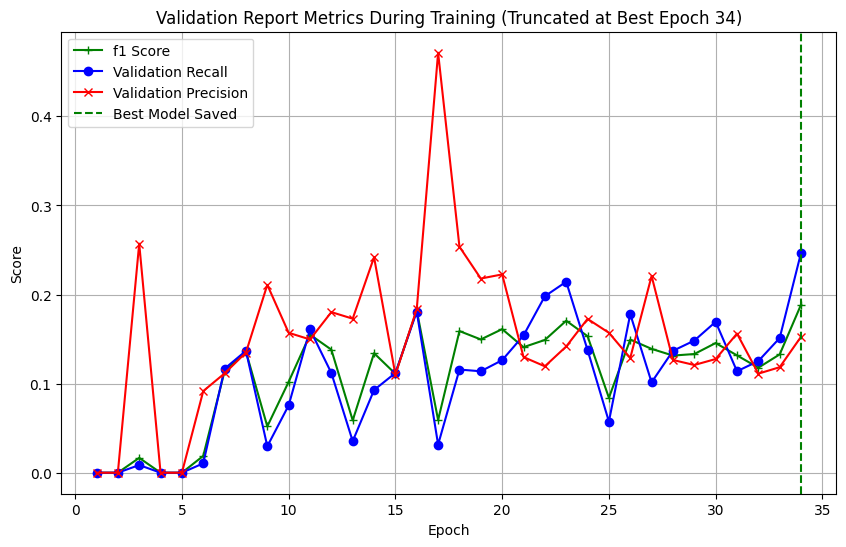

In [60]:
# Plot validation report metrics (f1-score, recall, precision)
plt.figure(figsize=(10, 6))
plt.plot(epochs, v_f1, label='f1 Score', marker='+', color='green')
plt.plot(epochs, v_recall, label='Validation Recall', marker='o', color='blue')
plt.plot(epochs, v_precision, label='Validation Precision', marker='x', color='red')
plt.axvline(x=best_epoch, color='green', linestyle='--', label='Best Model Saved')
plt.title(f'Validation Report Metrics During Training (Truncated at Best Epoch {best_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
# Load the best saved checkpoint
checkpoint = torch.load('detr_best_f1.pth', map_location=device)
model.load_state_dict(checkpoint)
model.to(device)
print('Loaded best model from saved checkpoint.')

# Evaluate on Test Set
evaluate_dual_metrics(model, test_loader_det, device, conf_threshold=0.1)

Loaded best model from saved checkpoint.
Starting Dual Evaluation (Conf: 0.1, IoU: 0.5)...


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]


CLASSIFICATION REPORT (Patient Diagnosis)
              precision    recall  f1-score   support

     Healthy       0.83      0.66      0.74      2916
    Fracture       0.37      0.60      0.46       972

    accuracy                           0.65      3888
   macro avg       0.60      0.63      0.60      3888
weighted avg       0.72      0.65      0.67      3888


DETECTION REPORT (Localization)
              precision    recall  f1-score   support

  Missed Box       0.00      0.00      0.00         0
   Found Box       1.00      0.27      0.42       972

    accuracy                           0.27       972
   macro avg       0.50      0.13      0.21       972
weighted avg       1.00      0.27      0.42       972



## Optimization

In [106]:
def find_best_threshold(model, dataloader, device, start=0.01, end=0.5, step=0.02):
    model.eval()
    
    # Store raw data to avoid re-running model
    all_pred_probs = [] 
    all_pred_boxes = []
    all_gt_boxes = []
    
    with torch.no_grad():
        print('Getting Predictions on Validation Set (Once)...')
        for images, targets in tqdm(dataloader, desc='Collecting Predictions'):
            pixel_values, _ = prepare_batch(images, targets, device, image_size=256, model_type='detr')
            outputs = model(pixel_values=pixel_values)
            
            # Get Probabilities
            probas = outputs.logits.softmax(-1)[..., 0]
            
            # Get and Scale Boxes
            pred_boxes = outputs.pred_boxes
            cx, cy, w, h = pred_boxes.unbind(-1)
            x1 = (cx - 0.5 * w) * 256
            y1 = (cy - 0.5 * h) * 256
            x2 = (cx + 0.5 * w) * 256
            y2 = (cy + 0.5 * h) * 256
            scaled_boxes = torch.stack([x1, y1, x2, y2], dim=-1)

            # Store ground truths and predictions
            for i in range(len(images)):
                all_pred_probs.append(probas[i].cpu())
                all_pred_boxes.append(scaled_boxes[i].cpu())
                
                # Handle GT boxes
                gt_box = targets[i]['boxes'].cpu()
                all_gt_boxes.append(gt_box)

    print('\nTesting Thresholds...')
    best_f1 = 0.0
    best_thresh = 0.0
    
    # Loop through thresholds
    thresholds = np.arange(start, end, step)
    
    for thresh in thresholds:
        y_true_det = []
        y_pred_det = []
        
        for i in range(len(all_pred_probs)):
            gt = all_gt_boxes[i]
            probs = all_pred_probs[i]
            boxes = all_pred_boxes[i]
            
            # Apply threshold 
            keep_idxs = probs > thresh
            pred_b = boxes[keep_idxs]
            
            # Check if Patient has Fracture (GT > 0)
            if len(gt) > 0 and gt.shape[-1] == 4:
                # Check if Model Predicted Fracture
                if len(pred_b) > 0 and pred_b.shape[-1] == 4:
                    ious = ops.box_iou(gt, pred_b)
                    max_ious, _ = ious.max(dim=1)
                    
                    # Hit if overlap > 0.5
                    is_hit = (max_ious > 0.5).any().item()
                    
                    y_true_det.append(1)
                    y_pred_det.append(1 if is_hit else 0)
                else:
                    # Missed (No prediction above threshold)
                    y_true_det.append(1)
                    y_pred_det.append(0)
            else:
                # Healthy Patient (GT=0)
                if len(pred_b) > 0:
                    # False Alarm
                    y_true_det.append(0)
                    y_pred_det.append(1)
                else:
                    # True Negative (Correctly ignored)
                    y_true_det.append(0)
                    y_pred_det.append(0)
        
        # Calculate F1 for this threshold
        curr_f1 = f1_score(y_true_det, y_pred_det, zero_division=0)
        
        if curr_f1 > best_f1:
            best_f1 = curr_f1
            best_thresh = thresh

    print(f'\n[*] BEST RESULT:')
    print(f'Best Threshold: {best_thresh:.2f}')
    print(f'Best F1-Score:  {best_f1:.4f}')
    
    return best_thresh

In [107]:
# Tune confidence threshold on validation set
print('Tuning Threshold on Validation Set...')
optimal_threshold = find_best_threshold(model, val_loader_det, device)

print(f'\nThe optimal confidence threshold is: {optimal_threshold:.2f}')

Tuning Threshold on Validation Set...
Getting Predictions on Validation Set (Once)...



Testing Thresholds...

[*] BEST RESULT:
Best Threshold: 0.01
Best F1-Score:  0.3174

The optimal confidence threshold is: 0.01


In [65]:
# Final evaluation on test set with optimal confidence threshold
print('Final Evaluation on Test Set...')
evaluate_dual_metrics(model, test_loader_det, device, conf_threshold=optimal_threshold)

Final Evaluation on Test Set...
Starting Dual Evaluation (Conf: 0.01, IoU: 0.5)...


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]


CLASSIFICATION REPORT (Patient Diagnosis)
              precision    recall  f1-score   support

     Healthy       0.98      0.25      0.40      2916
    Fracture       0.31      0.99      0.47       972

    accuracy                           0.44      3888
   macro avg       0.64      0.62      0.43      3888
weighted avg       0.81      0.44      0.42      3888


DETECTION REPORT (Localization)
              precision    recall  f1-score   support

  Missed Box       0.00      0.00      0.00         0
   Found Box       1.00      0.61      0.75       972

    accuracy                           0.61       972
   macro avg       0.50      0.30      0.38       972
weighted avg       1.00      0.61      0.75       972



In [111]:
# Visualize fracture truth/predictions
def visualize_fracture_predictions(model, dataloader, device, conf_threshold=0.01, num_images=4):
    model.eval()
    print(f'Scanning for {num_images} Fracture examples (Threshold: {conf_threshold})...')
    
    # Collect only fracture examples
    fracture_imgs = []
    fracture_targets = []
    
    # Iterate through dataloader until we have enough
    for batch_images, batch_targets in dataloader:
        for img, tgt in zip(batch_images, batch_targets):
            if len(tgt['boxes']) > 0: # Check if there is a Ground Truth box
                fracture_imgs.append(img)
                fracture_targets.append(tgt)
                
            if len(fracture_imgs) >= num_images:
                break
        if len(fracture_imgs) >= num_images:
            break
    
    print(f'Found {len(fracture_imgs)} fracture images. Running Inference...')

    # Run model for bounding box predictions
    pixel_values, _ = prepare_batch(fracture_imgs, fracture_targets, device, image_size=256, model_type='detr')
    
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
        
        # Get probabilities
        probas = outputs.logits.softmax(-1)[..., 0]
        # Keep boxes above threshold
        keep = probas > conf_threshold
        
        # Process boxes
        pred_boxes = outputs.pred_boxes
        cx, cy, w, h = pred_boxes.unbind(-1)
        x1 = (cx - 0.5 * w) * 256
        y1 = (cy - 0.5 * h) * 256
        x2 = (cx + 0.5 * w) * 256
        y2 = (cy + 0.5 * h) * 256
        w_px = w * 256
        h_px = h * 256
        pred_xywh = torch.stack([x1, y1, w_px, h_px], dim=-1)

    # Plot images with bounding boxes
    num_cols = 2
    num_rows = len(fracture_imgs)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 4 * num_rows))
    if num_rows == 1: axes = [axes]

    for i in range(num_rows):
        # Left for ground truth
        ax_gt = axes[i][0] if num_rows > 1 else axes[0]
        
        img_tensor = fracture_imgs[i]
        if img_tensor.shape[0] == 3:
            img_np = img_tensor.permute(1, 2, 0)
        else:
            img_np = img_tensor.squeeze(0)
            
        ax_gt.imshow(img_np, cmap='gray')
        ax_gt.set_title(f'Ground Truth (Fracture)')
        ax_gt.axis('off')
        
        # Draw GT Boxes (Green)
        for box in fracture_targets[i]['boxes']:
            box_data = box.tolist()
            if len(box_data) >= 4:
                x1, y1, x2, y2 = box_data[:4]
                w = x2 - x1
                h = y2 - y1
                rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='lime', facecolor='none')
                ax_gt.add_patch(rect)

        # Right for model prediction
        ax_pred = axes[i][1] if num_rows > 1 else axes[1]
        ax_pred.imshow(img_np, cmap='gray')
        ax_pred.set_title(f'Model Prediction (Conf > {conf_threshold})')
        ax_pred.axis('off')

        # Find the single best score for this image
        best_score, best_idx = probas[i].max(dim=0)
        
        # Only display if it passes the minimum safety threshold
        if best_score > conf_threshold:
            # Get the specific box
            top_box = pred_xywh[i][best_idx]
            
            # Extract coordinates
            box_data = top_box.tolist()
            x, y, w, h = box_data
            
            # Draw
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
            ax_pred.add_patch(rect)
            
            # Label
            label = f'Fracture: {best_score.item():.1%}'
            ax_pred.text(x, y-5, label, color='white', backgroundcolor='red', fontsize=9, weight='bold')
            ax_pred.set_title(f'Prediction (Top-1)')

    plt.tight_layout()
    plt.show()

Visualization loader created (Randomized).
Scanning for 4 Fracture examples (Threshold: 0.01)...
Found 4 fracture images. Running Inference...


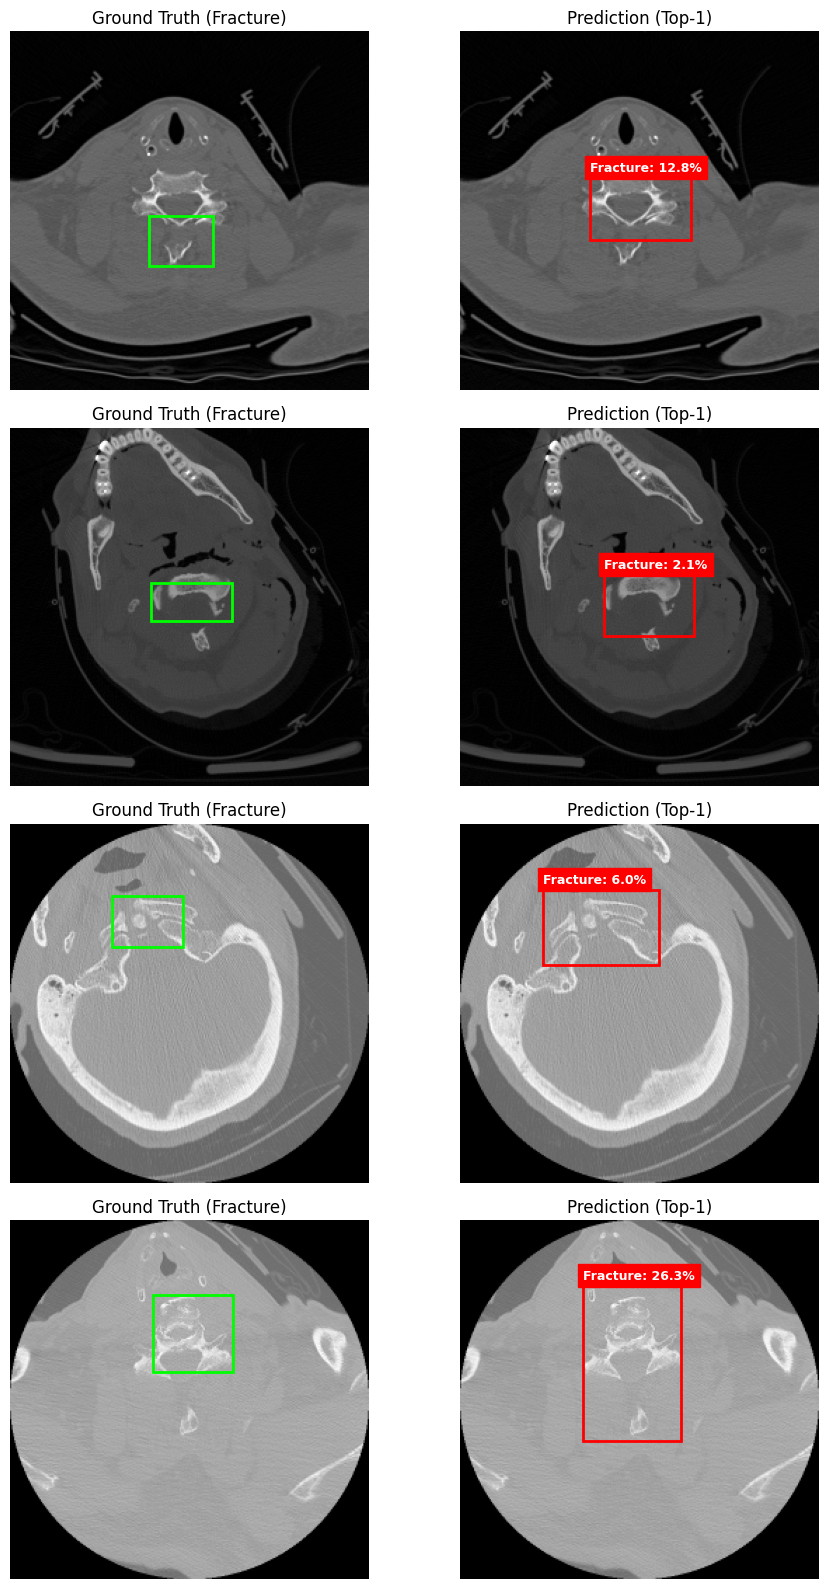

In [112]:
# Shuffle test set
vis_loader = DataLoader(
    test_loader_det.dataset,      
    batch_size=4,                 
    shuffle=True, # Set shuffle to true to see random images each time                
    num_workers=0,                
    collate_fn=test_loader_det.collate_fn,
    pin_memory=True
)

print('Visualization loader created (Randomized).')
visualize_fracture_predictions(model, vis_loader, device, conf_threshold=optimal_threshold, num_images=4)